## DQN train notebook 3D Convolutions

In [7]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
from cube import Cube
from tqdm import tqdm
from q_network import QNetwork2DConv, QNetwork3DConv
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
episodes = 10000
episode_len = 5

lr = 0.0001
buffer_size = 10000
batch_len = 32
gamma = 0.9
epsilon = 0.1
target_update_interval = 100
learning_starts = 100

avg_interval = 25

In [9]:
Q_net = QNetwork2DConv().to(device)
Q_net.train()

Q_target_net = deepcopy(Q_net)

optim = torch.optim.Adam(Q_net.parameters(), lr = lr)

replay_buffer = []

In [10]:
action_encode = {
    'F': 0,
    'F\'': 1,
    'B' : 2,
    'B\'': 3,
    'L' : 4,
    'L\'': 5,
    'R' : 6,
    'R\'': 7,
    'U' : 8,
    'U\'': 9,
    'D' : 10,
    'D\'': 11,
}
action_decode = {encoding : action for action, encoding in action_encode.items()}

def normalize_state2D(state):
    state = (state - 2.5) / 2.5
    state = torch.Tensor(state).to(device)
    return state

def normalize_state3D(state):
    state = (state - 2.5) / 2.5
    state = torch.Tensor(state).to(device).long()
    return state

# Change this when changing architecture
normalize_state = normalize_state2D

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:47<00:00, 59.60it/s]


Scramble steps: 1: 10.114497809410095


100%|██████████| 10000/10000 [04:08<00:00, 40.18it/s]


Scramble steps: 2: 11.834173259735108


100%|██████████| 10000/10000 [05:05<00:00, 32.70it/s]


Scramble steps: 3: 23.729712419509887


100%|██████████| 10000/10000 [05:24<00:00, 30.81it/s]


Scramble steps: 4: 56.69632183074951


100%|██████████| 10000/10000 [05:34<00:00, 29.91it/s]


Scramble steps: 5: 121.08265567779542


100%|██████████| 10000/10000 [05:33<00:00, 30.01it/s]


Scramble steps: 6: 145.45680236816406


100%|██████████| 10000/10000 [05:33<00:00, 29.97it/s]


Scramble steps: 7: 112.40501007080078


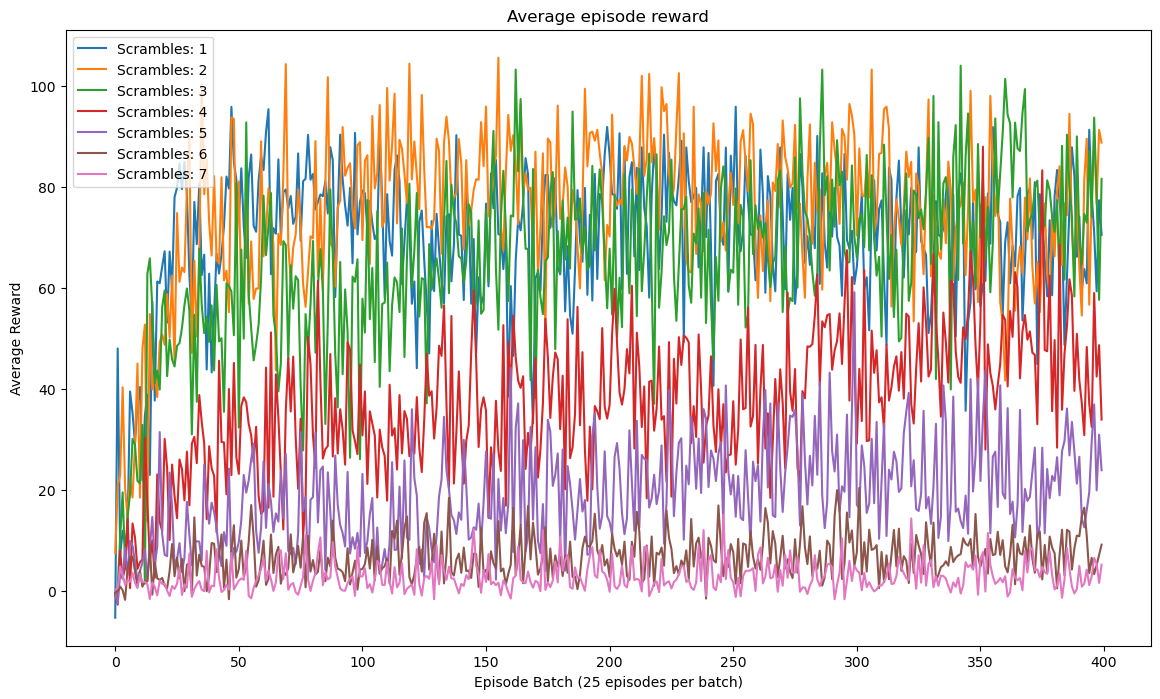

In [11]:

plt.figure(figsize=(14,8))

replay_buffer = []
eps_rewards = []
eps_losses = []


for scramble in range(1,8):
    Q_net = QNetwork2DConv().to(device)
    Q_net.train()

    Q_target_net = deepcopy(Q_net)

    optim = torch.optim.Adam(Q_net.parameters(), lr = lr)

    scramble_steps = scramble
    iters_since_target_update = 0
    it = 0
    eps_since_last_avg = 0
    ep_average_reward = 0
    ep_average_loss = 0
    ep_average_rewards = []
    ep_average_losses = []
    for ep in tqdm(range(episodes)):
        cube = Cube()
        cube.scramble(scramble_steps)
        s = np.copy(cube.facelets)
        
        for i in range(episode_len):
            with torch.no_grad():

                Q_pred = Q_net(torch.Tensor(normalize_state(s))[None, :].to(device))
            
            a = torch.argmax(Q_pred).item()
            # epsilon-greed here
            if np.random.uniform() < epsilon:
                a = np.random.randint(12)
            
            r = cube.rotate_code_get_reward(action_decode[a])
            s_prime = np.copy(cube.facelets)
            
            replay_buffer.append({'s': s, 'a': a, 'r': r, 's_prime': s_prime})
            if len(replay_buffer) > buffer_size:
                replay_buffer.pop(0)
            
            s = s_prime
            it += 1
            
            if it >= learning_starts:
                batch = np.random.choice(replay_buffer, batch_len, replace = False)
                batch_s = np.array([x['s'] for x in batch])
                batch_a = np.array([x['a'] for x in batch])
                batch_r = np.array([x['r'] for x in batch])
                batch_r = torch.Tensor(batch_r).to(device)
                batch_s_prime = np.array([x['s_prime'] for x in batch])
                
                Q_hat = Q_net(normalize_state(batch_s))[range(batch_len), torch.Tensor(batch_a).to(device).long()]
                
                with torch.no_grad():
                    Q_target = batch_r + gamma * torch.max(Q_target_net(normalize_state(batch_s_prime)), axis = 1).values
                    for j in range(batch_len):
                        if cube.is_solved_state(batch_s_prime[j]):
                            Q_target[j] = batch_r[j]
                
                optim.zero_grad()
                loss = torch.nn.MSELoss()(Q_hat, Q_target)
                # print(loss)
                loss.backward()
                
                optim.step()
                
                iters_since_target_update += 1
                if iters_since_target_update >= target_update_interval:
                    Q_target_net = deepcopy(Q_net)
                    iters_since_target_update = 0
                
                ep_average_reward += r
                ep_average_loss += loss.item()
                # print("LOSS",loss.item())
            
            if cube.is_solved_state(s):
                break
                
        eps_since_last_avg += 1
        if eps_since_last_avg >= avg_interval:
            ep_average_rewards.append(ep_average_reward / avg_interval)
            ep_average_losses.append(ep_average_loss / avg_interval)
            ep_average_reward = 0
            ep_average_loss = 0
            eps_since_last_avg = 0

    print(f"Scramble steps: {scramble_steps}: {ep_average_losses[-1]}")
    plt.plot(ep_average_rewards, label= f"Scrambles: {scramble_steps}")
    eps_rewards.append(ep_average_rewards)
    eps_losses.append(ep_average_losses)
    torch.save(Q_net.state_dict(), f"Q_net{scramble}.pt")

plt.title('Average episode reward')
plt.xlabel("Episode Batch (25 episodes per batch)")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

In [21]:
# plt.plot(ep_average_rewards)
# plt.title('Average episode reward')
# plt.legend()
# plt.show()

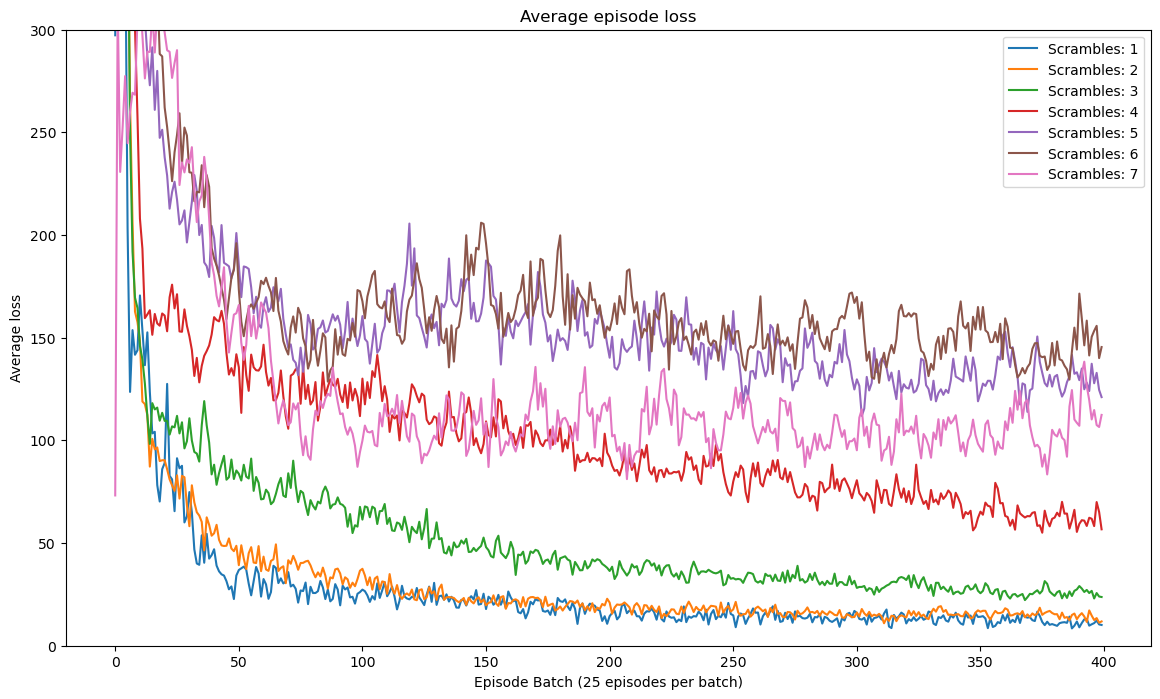

In [12]:
plt.figure(figsize=(14,8))

for i, ep_average_losses in enumerate(eps_losses):
    plt.plot(ep_average_losses, label=f"Scrambles: {i+1}" )
    plt.title('Average episode loss')
plt.legend()
plt.xlabel("Episode Batch (25 episodes per batch)")
plt.ylabel("Average loss")
plt.ylim(0,300)
plt.show()

90, 25